In [2]:
from math import pi, floor, asin
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import gdspy

# os.chdir(os.environ['WORKSPACE_FOLDER'])

from colorsys import hls_to_rgb

def colorize(z):
    n,m = z.shape
    c = np.zeros((n,m,3))
    c[np.isinf(z)] = (1.0, 1.0, 1.0)
    c[np.isnan(z)] = (0.5, 0.5, 0.5)

    idx = ~(np.isinf(z) + np.isnan(z))
    A = (np.angle(z[idx]) + np.pi) / (2*np.pi)
    A = (A + 0.5) % 1.0
    B = 1.0 - 1.0/(1.0+abs(z[idx])**0.3)
    c[idx] = [hls_to_rgb(a, b, 0.8) for a,b in zip(A,B)]
    return c


In [41]:
p = 2 * 0.31
size = 32 * p
nx, ny = int(size/p), int(size/p)
wl = 0.810  # um
k = 2*pi/wl

w, h = 195e-3, 0 # slot dimensions

meta_amp_filename = './deflectAbs.csv'
meta_arg_filename = './deflectArg.csv'
mata_mask_filename = './deflectMask.csv'

# meta_gds_output_filename = './hologram_hkustLogo_wl810_f150um_gsLoop100iter.gds'


In [31]:
four_slots_control([[1j]],[[1]])

array([[6.123234e-17+1.j, 6.123234e-17+1.j],
       [6.123234e-17+1.j, 6.123234e-17+1.j]])

(96, 96)


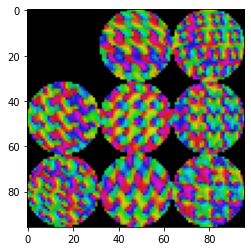

(2, 2, 96, 96)


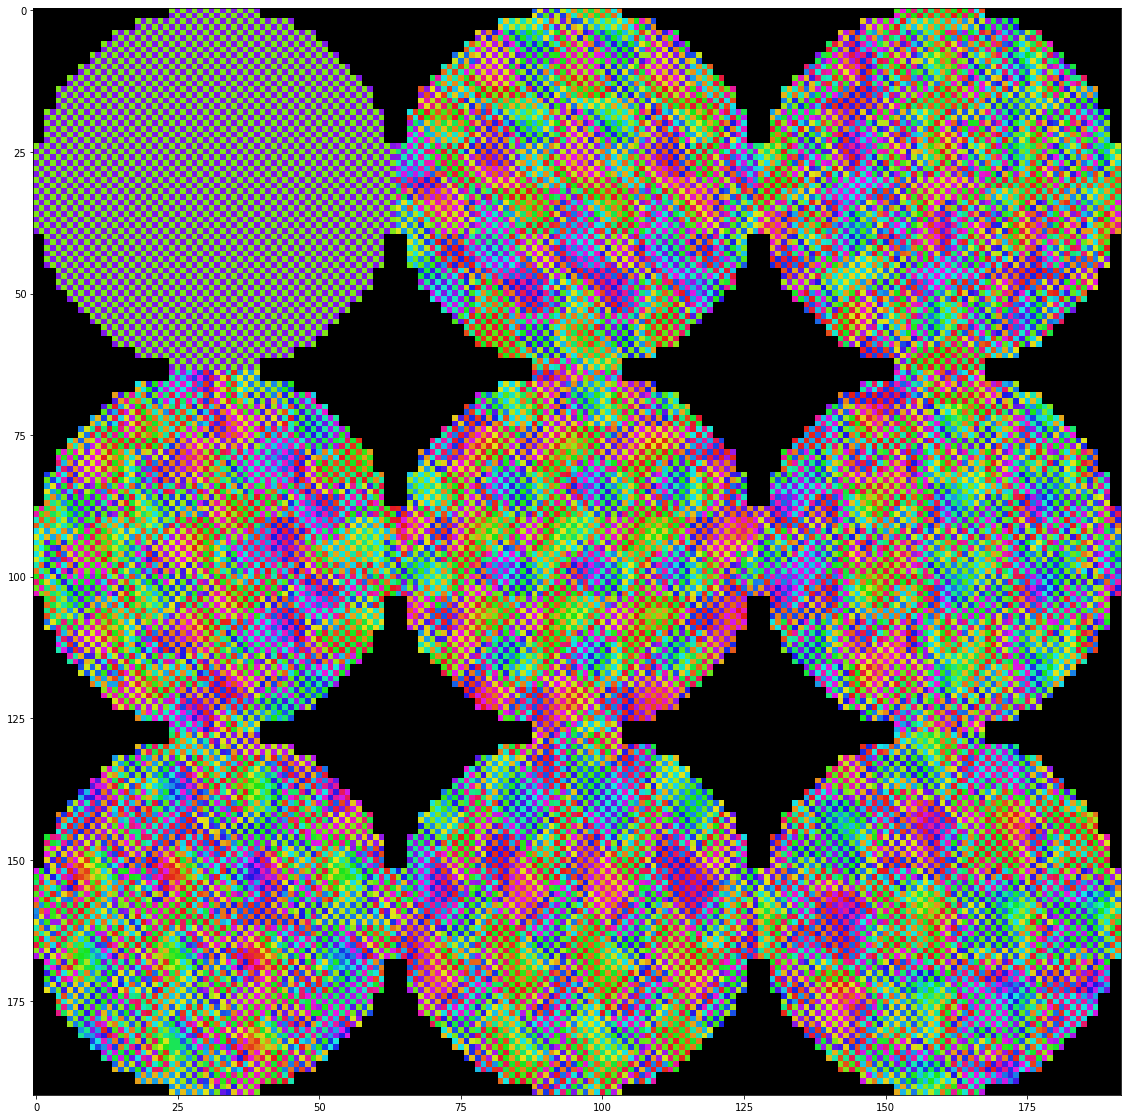

Loading from file ./deflectAbs.csv and ./deflectArg.csv
(2, 2, 96, 96)


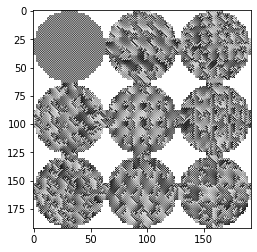

In [49]:

amp = np.loadtxt(meta_amp_filename, delimiter=',')
arg = np.loadtxt(meta_arg_filename, delimiter=',')
mask = np.loadtxt(mata_mask_filename, delimiter=',')
print(amp.shape)
assert amp.shape == arg.shape, "Different shape"

amp = amp / np.max(amp)
profile = amp * np.exp(1j * arg)

img = colorize(profile)
plt.imshow(img, cmap='gray')
plt.show()

def four_slots_control(profile, mask) -> np.ndarray:
    phase_plus = np.angle(profile) + np.arccos(np.abs(profile))
    phase_minus = np.angle(profile) - np.arccos(np.abs(profile))
    meta = np.array([[np.exp(1j*phase_plus), np.exp(1j*phase_minus)],
                     [np.exp(1j*phase_minus), np.exp(1j*phase_plus)]])
    print(meta.shape)
    meta = np.transpose(meta, (2, 0, 3, 1))
    meta = np.reshape(
        meta, (meta.shape[0]*meta.shape[1], meta.shape[2]*meta.shape[3]))
    mask = np.kron(mask, np.ones((2, 2)))
    meta[mask == 0] = np.nan
    return meta

nearfield = four_slots_control(profile, mask)
nearfield[np.isnan(nearfield)] = 0
plt.figure(figsize=(20,20))
plt.imshow(colorize(nearfield), cmap='gray')
plt.show()

np.savetxt('deflectPairAbs.csv', np.abs(nearfield), delimiter=',')
np.savetxt('deflectPairArg.csv', np.angle(nearfield), delimiter=',')

print(f'Loading from file {meta_amp_filename} and {meta_arg_filename}')
img_conv = np.angle(four_slots_control(profile, mask))
plt.imshow(img_conv, cmap='gray')
plt.show()


In [8]:
gdspy.current_library = gdspy.GdsLibrary()
lib = gdspy.GdsLibrary(unit=1e-6)

cell = lib.new_cell(meta_gds_output_filename)

meta = np.angle(four_slots_control(profile, mask))
meta_y = np.linspace(-3*size/2, 3*size/2, meta.shape[0])
meta_x = np.linspace(-3*size/2, 3*size/2, meta.shape[1])

for i in range(meta.shape[0]):
    for j in range(meta.shape[1]):
        if np.isnan(meta[i, j]):
            continue
        path = gdspy.FlexPath([
            (meta_x[i] - w/2*np.cos(meta[i, j]/2), meta_y[j] - w/2*np.sin(meta[i, j]/2)),
            (meta_x[i] + w/2*np.cos(meta[i, j]/2), meta_y[j] + w/2*np.sin(meta[i, j]/2))
        ], h, gdsii_path=True)
        cell.add(path)

print(f'Writing to file {meta_gds_output_filename}')
lib.write_gds(meta_gds_output_filename)

Writing to file ./metaLensf150Shift.gds


In [24]:
np.angle(four_slots_control([[0]]))*180/pi

array([[ 90., -90.],
       [-90.,  90.]])

In [11]:
np.arctan2((10.77700 - 10.72500), (11.43700-11.31200))*180/pi

22.58731053136557